In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=4a6a2c851f3bf6c690f11101716967ae6a22837077fbc31c444c7c874cd280d4
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as _sum, avg, count, max as _max

In [6]:

# Initialize Spark Session
spark = SparkSession.builder.appName("HealthcareDataAnalysis").getOrCreate()



file_path = "/home/Hospital_Data.csv"
# Specify the file path using wasbs protocol
healthcare_data_load = spark.read.csv(file_path, header=True, inferSchema=True)


In [7]:
healthcare_data_load.show()

+-------+-------------+------------------+------------------+--------------------+---------------------------------+------------+---------+------------------+---------+---------+-----------------+-----------------+-------------------+---------------------+-----+-----------------+------+
|case_id|Hospital_code|Hospital_type_code|City_Code_Hospital|Hospital_region_code|Available Extra Rooms in Hospital|  Department|Ward_Type|Ward_Facility_Code|Bed Grade|patientid|City_Code_Patient|Type of Admission|Severity of Illness|Visitors with Patient|  Age|Admission_Deposit|  Stay|
+-------+-------------+------------------+------------------+--------------------+---------------------------------+------------+---------+------------------+---------+---------+-----------------+-----------------+-------------------+---------------------+-----+-----------------+------+
|      1|            8|                 c|                 3|                   Z|                                3|radiotherapy|       

In [11]:

# Map/rename the raw columns to the desired column names
healthcare_data_renamed = healthcare_data_load \
    .withColumnRenamed("case_id", "CaseID") \
    .withColumnRenamed("Hospital_code", "HospitalCode") \
    .withColumnRenamed("Hospital_type_code", "HospitalTypeCode") \
    .withColumnRenamed("City_Code_Hospital", "CityCodeHospital") \
    .withColumnRenamed("Hospital_region_code", "HospitalRegionCode") \
    .withColumnRenamed("Available Extra Rooms in Hospital", "ExtraRoomsAvailable") \
    .withColumnRenamed("Department", "Department") \
    .withColumnRenamed("Ward_Type", "WardType") \
    .withColumnRenamed("Ward_Facility_Code", "WardFacilityCode") \
    .withColumnRenamed("Bed Grade", "BedGrade") \
    .withColumnRenamed("patientid", "PatientID") \
    .withColumnRenamed("City_Code_Patient", "CityCodePatient") \
    .withColumnRenamed("Type of Admission", "AdmissionType") \
    .withColumnRenamed("Severity of Illness", "IllnessSeverity") \
    .withColumnRenamed("Visitors with Patient", "VisitorsCount") \
    .withColumnRenamed("Age", "AgeGroup") \
    .withColumnRenamed("Admission_Deposit", "AdmissionDeposit") \
    .withColumnRenamed("Stay", "StayDuration")

# Display the data with renamed columns
healthcare_data_renamed.show(10)

+------+------------+----------------+----------------+------------------+-------------------+------------+--------+----------------+--------+---------+---------------+-------------+---------------+-------------+--------+----------------+------------+
|CaseID|HospitalCode|HospitalTypeCode|CityCodeHospital|HospitalRegionCode|ExtraRoomsAvailable|  Department|WardType|WardFacilityCode|BedGrade|PatientID|CityCodePatient|AdmissionType|IllnessSeverity|VisitorsCount|AgeGroup|AdmissionDeposit|StayDuration|
+------+------------+----------------+----------------+------------------+-------------------+------------+--------+----------------+--------+---------+---------------+-------------+---------------+-------------+--------+----------------+------------+
|     1|           8|               c|               3|                 Z|                  3|radiotherapy|       R|               F|       2|    31397|              7|    Emergency|        Extreme|            2|   51-60|            4911|      

In [12]:
# Step 2: Create Age Group Buckets
healthcare_data_age_groups = healthcare_data_renamed.withColumn(
    "AgeGroup_Label",
    when(col("AgeGroup") == "0-10", "Children")
    .when(col("AgeGroup") == "11-20", "Teens")
    .when(col("AgeGroup") == "21-30", "Young Adults")
    .when(col("AgeGroup") == "31-40", "Adults")
    .when(col("AgeGroup") == "41-50", "Middle-Aged Adults")
    .when(col("AgeGroup") == "51-60", "Seniors")
    .otherwise("Oldage")
)


In [14]:
healthcare_data_age_groups.show()

+------+------------+----------------+----------------+------------------+-------------------+------------+--------+----------------+--------+---------+---------------+-------------+---------------+-------------+--------+----------------+------------+--------------+
|CaseID|HospitalCode|HospitalTypeCode|CityCodeHospital|HospitalRegionCode|ExtraRoomsAvailable|  Department|WardType|WardFacilityCode|BedGrade|PatientID|CityCodePatient|AdmissionType|IllnessSeverity|VisitorsCount|AgeGroup|AdmissionDeposit|StayDuration|AgeGroup_Label|
+------+------------+----------------+----------------+------------------+-------------------+------------+--------+----------------+--------+---------+---------------+-------------+---------------+-------------+--------+----------------+------------+--------------+
|     1|           8|               c|               3|                 Z|                  3|radiotherapy|       R|               F|       2|    31397|              7|    Emergency|        Extreme| 

In [15]:
# Step 3: Calculate the Distribution of Patients Across Age Groups by Department
age_group_distribution = healthcare_data_age_groups.groupBy("Department", "AgeGroup_Label").count()
age_group_distribution.show()

+------------------+------------------+-----+
|        Department|    AgeGroup_Label|count|
+------------------+------------------+-----+
|        gynecology|            Adults|44154|
|TB & Chest disease|          Children|  252|
|           surgery|      Young Adults|   76|
|TB & Chest disease|            Adults| 1305|
|      radiotherapy|            Adults| 3097|
|        anesthesia|Middle-Aged Adults| 4697|
|        anesthesia|            Oldage| 8743|
|TB & Chest disease|Middle-Aged Adults| 1389|
|           surgery|          Children|   79|
|TB & Chest disease|            Oldage| 2306|
|        anesthesia|      Young Adults| 2802|
|        gynecology|            Oldage|56867|
|      radiotherapy|           Seniors| 3162|
|        gynecology|Middle-Aged Adults|43534|
|TB & Chest disease|      Young Adults| 1011|
|      radiotherapy|          Children|  663|
|TB & Chest disease|           Seniors| 1530|
|           surgery|            Adults|   98|
|        anesthesia|           Sen

In [16]:
# Step 4: Categorize Admission Deposits
healthcare_data_deposits = healthcare_data_renamed.withColumn(
    "Deposit_Category",
    when(col("AdmissionDeposit") < 2000, "Low")
    .when(col("AdmissionDeposit").between(2000, 5000), "Medium")
    .otherwise("High")
)

In [17]:
healthcare_data_deposits.show()

+------+------------+----------------+----------------+------------------+-------------------+------------+--------+----------------+--------+---------+---------------+-------------+---------------+-------------+--------+----------------+------------+----------------+
|CaseID|HospitalCode|HospitalTypeCode|CityCodeHospital|HospitalRegionCode|ExtraRoomsAvailable|  Department|WardType|WardFacilityCode|BedGrade|PatientID|CityCodePatient|AdmissionType|IllnessSeverity|VisitorsCount|AgeGroup|AdmissionDeposit|StayDuration|Deposit_Category|
+------+------------+----------------+----------------+------------------+-------------------+------------+--------+----------------+--------+---------+---------------+-------------+---------------+-------------+--------+----------------+------------+----------------+
|     1|           8|               c|               3|                 Z|                  3|radiotherapy|       R|               F|       2|    31397|              7|    Emergency|        Ext

In [18]:
# Step 5: Calculate the Average Admission Deposit by Hospital and Department
average_admission_deposit = healthcare_data_deposits.groupBy("HospitalCode", "Department").agg(
    avg("AdmissionDeposit").alias("Average_AdmissionDeposit")
)
average_admission_deposit.show()


+------------+------------------+------------------------+
|HospitalCode|        Department|Average_AdmissionDeposit|
+------------+------------------+------------------------+
|           8|           surgery|                 5508.25|
|          13|           surgery|       5334.583333333333|
|           2|      radiotherapy|       4980.271052631579|
|          16|        gynecology|       5102.519480519481|
|          31|      radiotherapy|       5163.922360248447|
|          29|TB & Chest disease|       5443.701818181818|
|          24|           surgery|       4841.833333333333|
|          13|TB & Chest disease|                5221.976|
|          11|TB & Chest disease|       5174.003565062389|
|          13|        gynecology|       5111.812465828321|
|          14|        anesthesia|       5233.181387333046|
|          22|        anesthesia|       5393.761061946902|
|          23|           surgery|       4796.809523809524|
|           2|        gynecology|      4999.411846884604

In [19]:
# Step 6: Count the Number of Patients by Illness Severity and Department
illness_severity_count = healthcare_data_renamed.groupBy("Department", "IllnessSeverity").count()
illness_severity_count.show()

+------------------+---------------+------+
|        Department|IllnessSeverity| count|
+------------------+---------------+------+
|        anesthesia|          Minor|  5594|
|        gynecology|          Minor| 51340|
|TB & Chest disease|        Extreme|  1575|
|TB & Chest disease|          Minor|  1770|
|        gynecology|        Extreme| 39118|
|      radiotherapy|        Extreme|  4881|
|TB & Chest disease|       Moderate|  4448|
|      radiotherapy|       Moderate| 13638|
|      radiotherapy|          Minor|  5315|
|        gynecology|       Moderate|114545|
|           surgery|        Extreme|   398|
|        anesthesia|       Moderate| 14533|
|           surgery|          Minor|    83|
|        anesthesia|        Extreme|  4873|
|           surgery|       Moderate|   570|
+------------------+---------------+------+



In [20]:
# Step 7: Calculate the Average Number of Visitors per Patient by Hospital and Department
average_visitors_count = healthcare_data_renamed.groupBy("HospitalCode", "Department").agg(
    avg("VisitorsCount").alias("Average_VisitorsCount")
)
average_visitors_count.show()


+------------+------------------+---------------------+
|HospitalCode|        Department|Average_VisitorsCount|
+------------+------------------+---------------------+
|           8|           surgery|                3.375|
|          13|           surgery|                 3.75|
|           2|      radiotherapy|   3.1052631578947367|
|          16|        gynecology|    3.069264069264069|
|          31|      radiotherapy|    2.900621118012422|
|          29|TB & Chest disease|    3.101818181818182|
|          24|           surgery|                  3.5|
|          13|TB & Chest disease|                3.008|
|          11|TB & Chest disease|    3.516934046345811|
|          13|        gynecology|    2.960087479496993|
|          14|        anesthesia|    2.981473502800517|
|          22|        anesthesia|   2.9292035398230087|
|          23|           surgery|   3.9404761904761907|
|           2|        gynecology|    3.191394244202291|
|          21|      radiotherapy|   3.1337907375

In [21]:
# Step 8: Identify Departments with the Highest Revenue
department_revenue = healthcare_data_renamed.groupBy("Department").agg(
    _sum("AdmissionDeposit").alias("TotalRevenue")
)
department_revenue.show()

+------------------+------------+
|        Department|TotalRevenue|
+------------------+------------+
|      radiotherapy|   118022614|
|        anesthesia|   132773661|
|TB & Chest disease|    40136552|
|        gynecology|   991154468|
|           surgery|     5194042|
+------------------+------------+



In [22]:
# Step 9: Identify Departments with the Most Emergency Admissions
emergency_admissions = healthcare_data_renamed.filter(col("AdmissionType") == "Emergency").groupBy("Department").count()
emergency_admissions.orderBy(col("count").desc()).show()


+------------------+-----+
|        Department|count|
+------------------+-----+
|        gynecology|78398|
|      radiotherapy|10139|
|        anesthesia| 4899|
|TB & Chest disease| 2580|
|           surgery| 1010|
+------------------+-----+



In [23]:
# Step 10: Identify the Department with the Highest Total Visitors
total_visitors_by_dept = healthcare_data_renamed.groupBy("Department").agg(
    _sum("VisitorsCount").alias("Total_Visitors")
)
highest_visitor_dept = total_visitors_by_dept.orderBy(col("Total_Visitors").desc()).limit(1)
highest_visitor_dept.show()

+----------+--------------+
|Department|Total_Visitors|
+----------+--------------+
|gynecology|        677862|
+----------+--------------+



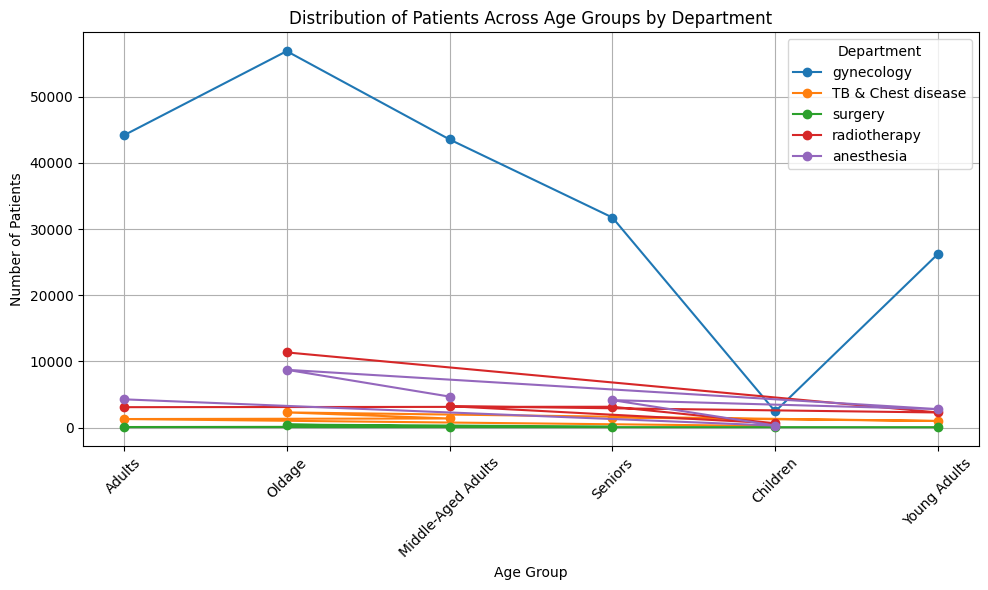

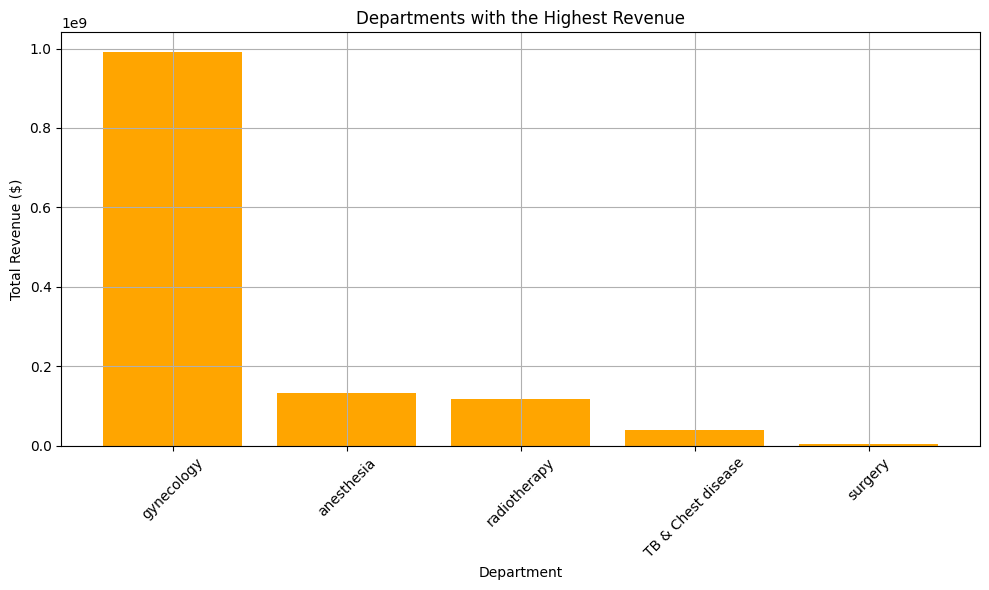

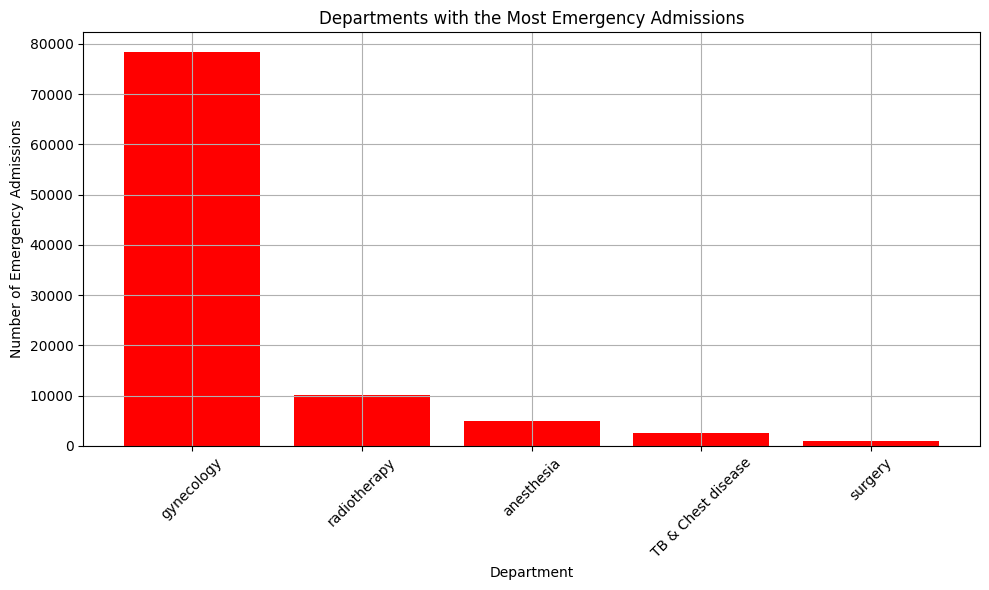

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the SparkSession and DataFrames from the previous code are available

# Convert PySpark DataFrames to Pandas DataFrames for visualization
age_group_distribution_pd = age_group_distribution.toPandas()
average_admission_deposit_pd = average_admission_deposit.toPandas()
department_revenue_pd = department_revenue.toPandas()
emergency_admissions_pd = emergency_admissions.orderBy(col("count").desc()).toPandas()

# Chart 1: Distribution of Patients Across Age Groups by Department
plt.figure(figsize=(10, 6))
for department in age_group_distribution_pd['Department'].unique():
    subset = age_group_distribution_pd[age_group_distribution_pd['Department'] == department]
    plt.plot(subset['AgeGroup_Label'], subset['count'], marker='o', label=department)
plt.title('Distribution of Patients Across Age Groups by Department')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.legend(title='Department')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Chart 2: Departments with the Highest Revenue
department_revenue_pd = department_revenue_pd.sort_values(by="TotalRevenue", ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(department_revenue_pd['Department'], department_revenue_pd['TotalRevenue'], color='orange')
plt.title('Departments with the Highest Revenue')
plt.xlabel('Department')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Chart 3: Department with the Most Emergency Admissions
plt.figure(figsize=(10, 6))
plt.bar(emergency_admissions_pd['Department'], emergency_admissions_pd['count'], color='red')
plt.title('Departments with the Most Emergency Admissions')
plt.xlabel('Department')
plt.ylabel('Number of Emergency Admissions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
